In [29]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from joblib import load
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from keras.models import Sequential
from keras.layers import Dense, Dropout

In [2]:
# Paths to the zip files
train_zip_path = '../data/processed/train_data.zip'
val_zip_path = '../data/processed/val_data.zip'
test_zip_path = '../data/processed/test_data.zip'

# Load train, validation, and test data from zip files
def load_zipped_csv(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as z:
        # Extract CSV file inside the zip and read it into a DataFrame
        with z.open(z.namelist()[0]) as f:
            return pd.read_csv(f)

# Load the data
train_data = load_zipped_csv(train_zip_path)
val_data = load_zipped_csv(val_zip_path)
test_data = load_zipped_csv(test_zip_path)

# Print shapes to verify
print(f"Training data shape: {train_data.shape}")
print(f"Validation data shape: {val_data.shape}")
print(f"Testing data shape: {test_data.shape}")

Training data shape: (40000, 5000)
Validation data shape: (5000, 5000)
Testing data shape: (5000, 5000)


In [3]:
# Load the saved TF-IDF vectorizer
tfidf_vectorizer = load('../models/tfidf_vectorizer.joblib')

In [4]:
X_train_tfidf = train_data.drop(columns=['sentiment'])  # Drop the target column to get feature matrix
y_train = train_data['sentiment']  # Target column (sentiment)

X_val_tfidf = val_data.drop(columns=['sentiment'])
y_val = val_data['sentiment']

### Naive Bayes Model

In [5]:
# Initialize and train the Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

MultinomialNB()

In [6]:
# Predict on the validation data
y_val_pred = nb_model.predict(X_val_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {accuracy}")
print(classification_report(y_val, y_val_pred))


Validation Accuracy: 0.8544
              precision    recall  f1-score   support

    negative       0.85      0.86      0.85      2499
    positive       0.86      0.85      0.85      2501

    accuracy                           0.85      5000
   macro avg       0.85      0.85      0.85      5000
weighted avg       0.85      0.85      0.85      5000



In [7]:
# Load the preprocessed test data
X_test_tfidf = test_data.drop(columns=['sentiment'])
y_test = test_data['sentiment']

# Make predictions on the test data
y_test_pred = nb_model.predict(X_test_tfidf)

# Evaluate the model on the test data
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy}")
print(classification_report(y_test, y_test_pred))

Test Accuracy: 0.8518
              precision    recall  f1-score   support

    negative       0.85      0.84      0.85      2462
    positive       0.85      0.86      0.86      2538

    accuracy                           0.85      5000
   macro avg       0.85      0.85      0.85      5000
weighted avg       0.85      0.85      0.85      5000



## Building DNN

In [8]:
# Label Mapping
y_train = train_data['sentiment'].map({'negative': 0, 'positive': 1})
y_val = val_data['sentiment'].map({'negative': 0, 'positive': 1})
y_test = test_data['sentiment'].map({'negative': 0, 'positive': 1})

# Conversion to NumPy Arrays
X_train_tfidf = np.array(X_train_tfidf)
X_val_tfidf = np.array(X_val_tfidf)
y_train = np.array(y_train)
y_val = np.array(y_val)

In [10]:
# Build a simple neural network with fully connected layers
model = Sequential()
model.add(Dense(512, input_shape=(X_train_tfidf.shape[1],), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_tfidf, y_train, validation_data=(X_val_tfidf, y_val), epochs=10, batch_size=64)

Epoch 1/10
625/625 [==============================] - 24s 36ms/step - loss: 0.3224 - accuracy: 0.8593 - val_loss: 0.2798 - val_accuracy: 0.8798
Epoch 2/10
625/625 [==============================] - 23s 37ms/step - loss: 0.2210 - accuracy: 0.9111 - val_loss: 0.2849 - val_accuracy: 0.8830
Epoch 3/10
625/625 [==============================] - 23s 37ms/step - loss: 0.1533 - accuracy: 0.9441 - val_loss: 0.3211 - val_accuracy: 0.8802
Epoch 4/10
625/625 [==============================] - 23s 37ms/step - loss: 0.0679 - accuracy: 0.9791 - val_loss: 0.4017 - val_accuracy: 0.8794
Epoch 5/10
625/625 [==============================] - 24s 38ms/step - loss: 0.0254 - accuracy: 0.9928 - val_loss: 0.5063 - val_accuracy: 0.8754
Epoch 6/10
625/625 [==============================] - 23s 37ms/step - loss: 0.0133 - accuracy: 0.9965 - val_loss: 0.5912 - val_accuracy: 0.8764
Epoch 7/10
625/625 [==============================] - 24s 38ms/step - loss: 0.0101 - accuracy: 0.9967 - val_loss: 0.6149 - val_accuracy:

In [12]:
# Evaluate the model
test_loss, test_acc = model.evaluate(np.array(X_test_tfidf), np.array(y_test))
print(f'Test Accuracy: {test_acc:.4f}')

157/157 [==============================] - 1s 3ms/step - loss: 0.7000 - accuracy: 0.8868
Test Accuracy: 0.8868


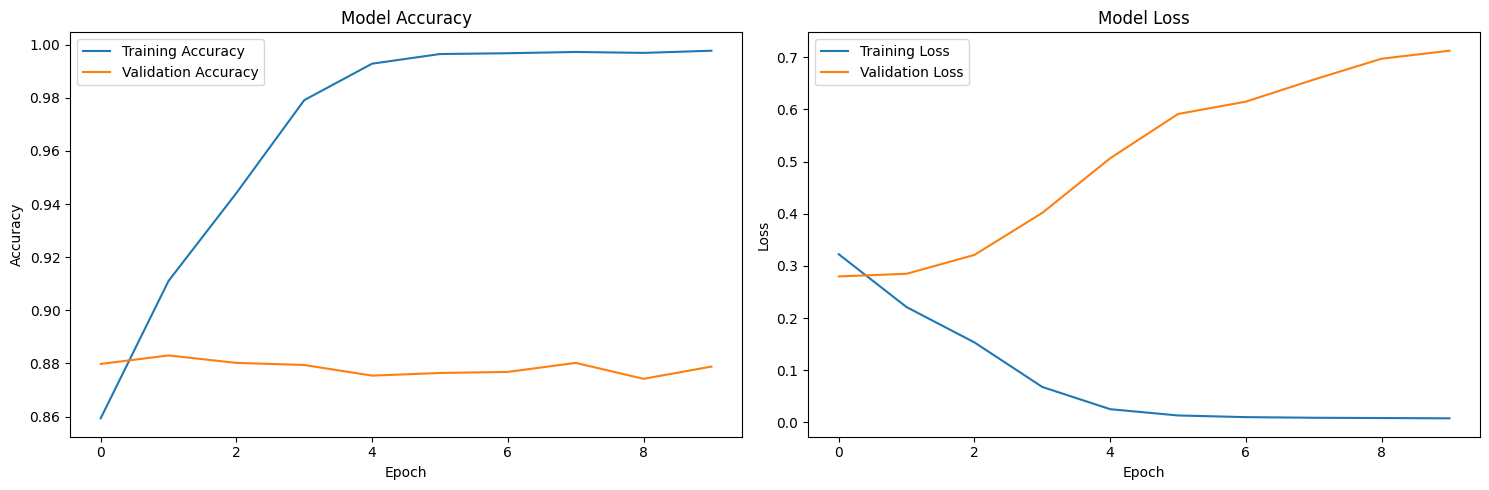

In [26]:
# Create subplots with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
ax1.plot(history.history['accuracy'], label='Training Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend()

# Plot loss
ax2.plot(history.history['loss'], label='Training Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend()

# Show the plots
plt.tight_layout()

plt.savefig('../reports/training.png')
plt.show()

157/157 [==============================] - 0s 3ms/step


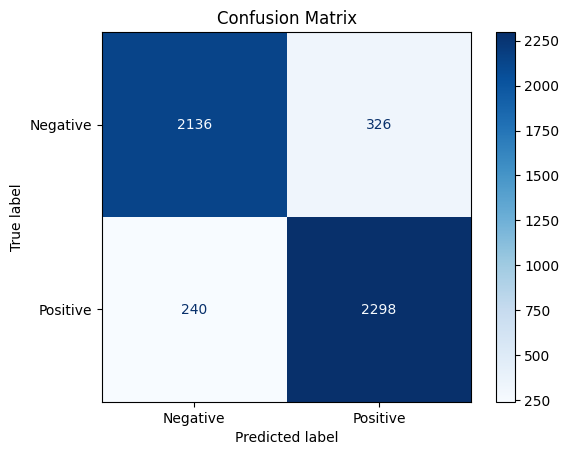

In [27]:
# Make predictions on the test set
y_pred = (model.predict(np.array(X_test_tfidf)) > 0.5).astype("int32")

# Generate the confusion matrix
cm = confusion_matrix(np.array(y_test), y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.savefig('../reports/confusion_matrix.png')
plt.show()

157/157 [==============================] - 1s 3ms/step


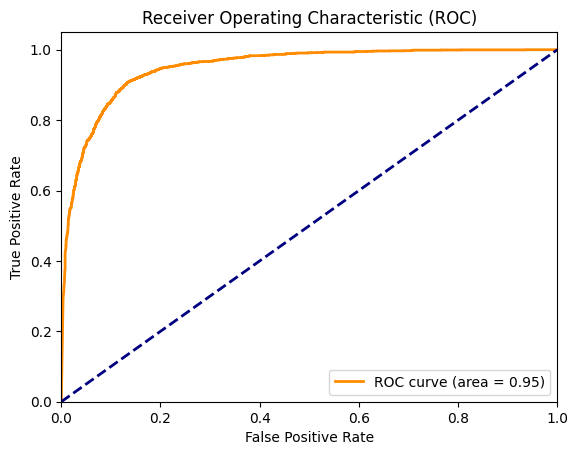

In [30]:
# Get prediction probabilities
y_pred_prob = model.predict(np.array(X_test_tfidf))

# Compute ROC curve
fpr, tpr, _ = roc_curve(np.array(y_test), y_pred_prob)

# Compute AUC score
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.savefig('../reports/roc.png')
plt.show()

In [13]:
# Save the trained model
model.save('../models/sentiment_analysis_model.keras')